## <span style="color:orange; font-weight:bold">GeoPOINT – Synthetic Point Generator for Geospatial Applications</span>

### <span style="color:red; font-weight:bold">Structure of the GeoPOINT Script</span>

This notebook consists of the following key components:

- **Importing required libraries** for numerical processing, visualization, symbolic computation, and file handling.
&nbsp;
- **User configuration parameters.**  
  These parameters define the number of points, transformation settings, and the characteristics of synthetic noise and geodetic distortion.
&nbsp;
- **Generation of synthetic points** on a spherical surface in the fixed (global) frame.  
  Three variants are supported:
  1. Ideal points (noise-free);  
  2. Points with added random Gaussian noise;  
  3. Points with combined random noise and geodetic distortion model (simulating real-world measurement errors).  
&nbsp;
- **Transformation of point coordinates** into a local (body) frame using parameters defined in the configuration.

- **Export of both coordinate sets** (fixed and local) to Excel (`.xlsx`) files for further analysis or benchmarking.

- **Visualization and statistics** summarizing the generated and transformed data.


### <span style="color:darkgreen; font-weight:bold">Importing Required Libraries</span>

This section imports the Python libraries used throughout the notebook.

- **NumPy** and **pandas** are used for numerical computation and tabular data handling.
- **Matplotlib** (with `mpl_toolkits.mplot3d`) is used for 3D visualization.
- **SymPy** is used for symbolic representation of rotation matrices.
- **JSON** and **os** provide configuration file support and system integration.
- **openpyxl** is used internally by `pandas` for exporting Excel spreadsheets.

All libraries used are open-source and compatible with standard scientific Python environments.


In [2]:
# === Import Required Libraries ===

# Core numerical and data processing
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Symbolic mathematics
import sympy as sp

# File handling and configuration
import json

# Excel export (via pandas)
from openpyxl import Workbook


### <span style="color:darkgreen; font-weight:bold">User Configuration Parameters</span>

This dictionary contains all key parameters governing synthetic point generation,  
geodetic error simulation, spatial transformation, and the addition of measurement noise.  
All values can be freely edited in this notebook and reflect typical properties of total stations


In [3]:
# === Configuration Parameters (editable by the user) ===

config = {
    # --- Point generation (fixed frame) ---
    "npoints": 50,  # Number of synthetic points to generate
    "radius": 50.0,  # Nominal radius of the generated spherical surface [m]

    # Geodetic error model (used for distortion)
    "A": 0.005,      # Distance meter constant error (instrument offset) [m]
    "B": 7.0,        # Distance-dependent error (proportional term) [ppm]
    "angle_noise_arcsec": 1.0,  # Simulated instrument angular precision (standard deviation) [arcseconds]

    # --- Rotation parameters (in grads) ---
    "roll": 5,       # Rotation about X axis (clockwise)
    "pitch": 5,      # Rotation about Y axis (anticlockwise)
    "yaw": 40,       # Rotation about Z axis (clockwise)

    # --- Translation parameters (in meters) ---
    "dx": 10.0,      # Translation along X axis
    "dy": 10.0,      # Translation along Y axis
    "dz": 2.0,       # Translation along Z axis

    # --- Noise added to transformed points (body frame) ---
    "gaussian_std": 0.01,   # Standard deviation of Gaussian noise [m]
    "bias": 0.002          # Constant bias added to all coordinates [m]
}


### <span style="color:darkgreen; font-weight:bold">Generation of Synthetic Points – Fixed Frame</span>

In this step, synthetic 3D points are generated over a spherical surface to simulate geodetic observations 
in an ideal global coordinate system (fixed frame).

The point generation can apply three different modes of increasing realism:

- **Ideal (noise-free):** applies no disturbance; purely mathematical coordinates, uniformly distributed on the sphere.
- **With random Gaussian noise:** applies stochastic errors by perturbing angles or Cartesian coordinates.
- **With geodetic distortion model:** applies both random noise and systematic errors based on typical properties of a Total Station, 
  including EDM (Electronic Distance Meter) range error parameters (`A`, `B`) and angular precision (in arcseconds) as defined in the `config` dictionary.

The selected variant can be easily changed by switching the called function below.


In [4]:
def generate_angles(config):
    """
    Generate base spherical angles (theta, phi) for reproducible point sets.
    """
    npoints = config["npoints"]
    theta = np.random.uniform(0, 2 * np.pi, npoints)
    phi = np.arccos(1 - 2 * np.random.uniform(0, 1, npoints))
    return theta, phi


In [5]:
def uniform_spherical(config, theta=None, phi=None):
    """
    Generate ideal 3D points uniformly distributed on the surface of a sphere,
    representing noise-free geodetic observations from a fixed global reference frame.

    Parameters:
        config (dict): Dictionary containing generation parameters:
            - 'npoints': Number of points to generate.
            - 'radius': Nominal distance from origin [m].
        theta (np.ndarray, optional): Predefined azimuthal angles [rad].
        phi (np.ndarray, optional): Predefined zenith angles [rad].

    Returns:
        points (np.ndarray): 3×N array of Cartesian coordinates [m].
        theta (np.ndarray): Azimuthal angles [rad].
        phi (np.ndarray): Zenith angles [rad].
    """
    npoints = config["npoints"]
    radius = config["radius"]

    # --- Generate or use predefined angles ---
    if theta is None or phi is None:
        theta = np.random.uniform(0, 2 * np.pi, npoints)
        phi = np.arccos(1 - 2 * np.random.uniform(0, 1, npoints))

    # --- Convert spherical to Cartesian coordinates ---
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    return np.vstack((x, y, z)), theta, phi


In [6]:
def uniform_spherical_with_noise(config, theta=None, phi=None):
    """
    Generate 3D points on a spherical surface with added Gaussian noise to angles,
    then convert to Cartesian coordinates and scale by user-defined radius.

    Parameters:
        config (dict): Includes 'npoints', 'radius', and 'angle_noise_arcsec'.
        theta (np.ndarray, optional): Base azimuthal angles [rad] to perturb.
        phi (np.ndarray, optional): Base zenith angles [rad] to perturb.

    Returns:
        points (np.ndarray): 3×N array of noisy 3D coordinates [m]
        theta (np.ndarray): perturbed azimuthal angles [rad]
        phi (np.ndarray): perturbed zenith angles [rad]
    """
    npoints = config["npoints"]
    radius = config["radius"]

    # Arcseconds to radians conversion
    rho = 180 * 3600 / np.pi  # arcseconds per radian
    angle_noise = config["angle_noise_arcsec"] / rho

    # Generate or copy angles
    if theta is None or phi is None:
        theta = np.random.uniform(0, 2 * np.pi, npoints)
        phi = np.arccos(1 - 2 * np.random.uniform(0, 1, npoints))
    else:
        # Ensure correct size
        assert len(theta) == npoints and len(phi) == npoints, "Angle arrays must match npoints"
        theta = theta.copy()
        phi = phi.copy()

    # Add Gaussian angular noise
    theta += angle_noise * np.random.randn(npoints)
    phi += angle_noise * np.random.randn(npoints)

    # Spherical to Cartesian conversion
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    return np.vstack((x, y, z)), theta, phi


In [7]:
def uniform_spherical_with_geodetic_distortion(config, theta=None, phi=None):
    """
    Generate synthetic 3D points using a geodetic error model that includes both angular noise 
    and EDM-based range errors representative of typical total station measurements.

    Parameters:
        config (dict): Configuration dictionary with the following keys:
            - npoints: Number of points to generate
            - radius: Nominal distance from origin [m]
            - A: Constant EDM error [m]
            - B: Proportional EDM error [ppm]
            - angle_noise_arcsec: Angular noise (standard deviation) [arcseconds]
        theta (np.ndarray, optional): Base azimuth angles [rad]
        phi (np.ndarray, optional): Base zenith angles [rad]

    Returns:
        points (np.ndarray): 3×N array of perturbed 3D coordinates [m]
        theta (np.ndarray): Azimuth angles with angular noise [rad]
        phi (np.ndarray): Zenith angles with angular noise [rad]
        R (np.ndarray): Simulated range from origin for each point [m], including EDM errors
    """
    npoints = config["npoints"]
    radius = config["radius"]
    A = config["A"]
    B = config["B"]

    # Arcseconds to radians conversion
    rho = 180 * 3600 / np.pi
    angle_noise = config["angle_noise_arcsec"] / rho

    # Generate or copy base angles
    if theta is None or phi is None:
        theta = np.random.uniform(0, 2 * np.pi, npoints)
        phi = np.arccos(1 - 2 * np.random.uniform(0, 1, npoints))
    else:
        assert len(theta) == npoints and len(phi) == npoints, "Angle arrays must match npoints"
        theta = theta.copy()
        phi = phi.copy()

    # Add angular noise
    theta += angle_noise * np.random.randn(npoints)
    phi += angle_noise * np.random.randn(npoints)

    # Convert to unit direction vectors
    x_unit = np.sin(phi) * np.cos(theta)
    y_unit = np.sin(phi) * np.sin(theta)
    z_unit = np.cos(phi)

    # Ideal range
    S = radius * np.ones_like(x_unit)

    # Add EDM noise
    m_S = A + B * 1e-6 * S  # B in ppm
    R = S + m_S * np.random.randn(npoints)

    # Scale vectors by range
    x = R * x_unit
    y = R * y_unit
    z = R * z_unit

    return np.vstack((x, y, z)), theta, phi, R


### <span style="color:darkgreen; font-weight:bold">Coordinates Transformation – Body Frame</span>

In this step, the synthetic 3D points generated in the fixed (global) frame are transformed  
into a local coordinate system (body frame) defined by user-specified parameters.

The transformation consists of:

- **Translation** along the X, Y, and Z axes;  
- **Rotation** (roll, pitch, yaw), applied in a defined order using standard rotation matrices;  
- Optional **scaling**, if needed, to simulate dimensional adjustments.

Rotation angles are specified in **gradians**, following geodetic conventions,  
and are internally converted to **radians** prior to matrix computation.

This step emulates typical geodetic operations such as aligning local measurements  
(e.g., from a vessel or offshore platform) with a known reference coordinate system.

The transformed coordinates are subsequently made available for export, benchmarking, or further analysis.


In [8]:
# === Rotation and Translation to Local Frame (Body Frame) ===

# --- Load rotation and translation parameters from config ---
roll = config["roll"]
pitch = config["pitch"]
yaw = config["yaw"]
dx = config["dx"]
dy = config["dy"]
dz = config["dz"]

# --- Convert rotation angles from grads to radians ---
to_rad = np.pi / 200
rx = roll * to_rad
ry = pitch * to_rad
rz = yaw * to_rad

# --- Define symbolic variables for rotation angles ---
rx_sym, ry_sym, rz_sym = sp.symbols('rx ry rz')

# --- Symbolic rotation matrices ---
Rx_sym = sp.Matrix([
    [1, 0, 0],
    [0, sp.cos(rx_sym), sp.sin(rx_sym)],
    [0, -sp.sin(rx_sym), sp.cos(rx_sym)]
])

Ry_sym = sp.Matrix([
    [sp.cos(ry_sym), 0, -sp.sin(ry_sym)],
    [0, 1, 0],
    [sp.sin(ry_sym), 0, sp.cos(ry_sym)]
])

Rz_sym = sp.Matrix([
    [sp.cos(rz_sym), sp.sin(rz_sym), 0],
    [-sp.sin(rz_sym), sp.cos(rz_sym), 0],
    [0, 0, 1]
])

# --- Combined symbolic rotation matrix ---
R_sym = Rz_sym * Ry_sym * Rx_sym
R_numerical = R_sym.subs({rx_sym: rx, ry_sym: ry, rz_sym: rz})
R = np.array(R_numerical.evalf()).astype(np.float64)

# --- Define symbolic variables for parametric rotation matrix ---
a1, a2, a3 = sp.symbols('a1 a2 a3')
b1, b2, b3 = sp.symbols('b1 b2 b3')
c1, c2, c3 = sp.symbols('c1 c2 c3')

R_sym_symbols = R_sym.subs({
    R_sym[0, 0]: a1, R_sym[0, 1]: b1, R_sym[0, 2]: c1,
    R_sym[1, 0]: a2, R_sym[1, 1]: b2, R_sym[1, 2]: c2,
    R_sym[2, 0]: a3, R_sym[2, 1]: b3, R_sym[2, 2]: c3
})

# --- Define translation vector ---
T = np.array([[dx], [dy], [dz]])

# --- Generate base spherical coordinates (shared for all variants) ---
P_base, theta_base, phi_base = uniform_spherical(config)

# --- Define generator functions with shared angular base ---
generators = [
    ("ideal", lambda cfg: (P_base, theta_base, phi_base)),
    ("with_noise", lambda cfg: uniform_spherical_with_noise(cfg, theta=theta_base, phi=phi_base)),
    ("with_geodetic_distortion", lambda cfg: uniform_spherical_with_geodetic_distortion(cfg, theta=theta_base, phi=phi_base))
]

# --- Prepare dictionary to store transformed point sets ---
transformed_sets = {}

# --- Iterate through each generator and apply transformation ---
for label, generator in generators:
    print(f"\n\033[1m=== Transforming points: {label} ===\033[0m")

    result = generator(config)

    if len(result) == 3:
        points, theta, phi = result
    else:
        points, theta, phi, _ = result

    # Ensure shape (3, N)
    P = points if points.shape[0] == 3 else points.T

    # Apply transformation
    PP = R @ P + T

    # Optional post-transform noise in the body frame ---
    sigma = float(config.get("gaussian_std", 0.0))  # [m]
    bias  = float(config.get("bias", 0.0))          # [m]

    if (sigma != 0.0 or bias != 0.0) and label != "ideal":
        noise = np.random.normal(loc=0.0, scale=sigma, size=PP.shape)   
        bias_vec = np.array([[bias], [bias], [bias]], dtype=float)      
        PP = PP + noise + bias_vec
 
    # Save to dictionary
    transformed_sets[label] = {
        "P_original": P,
        "P_transformed": PP,
        "theta": theta,
        "phi": phi
    }

    # Print first 3 transformed coordinates
    print("\033[1mTransformed coordinates (first 3 points):\033[0m")
    print(PP[:, :3].T)

# --- Print matrix and angle information ---
print("\033[1m\nRotation around X-axis (radians):\033[0m", rx)
print("\033[1m\nRotation around Y-axis (radians):\033[0m", ry)
print("\033[1m\nRotation around Z-axis (radians):\033[0m", rz)

print("\033[1m\nSymbolic rotation matrix:\033[0m")
print(sp.pretty(R_sym, use_unicode=False, wrap_line=False))

print("\033[1m\nNumerical rotation matrix for configured angles:\033[0m")
print(sp.pretty(R_numerical.evalf(), use_unicode=False, wrap_line=False))

print("\033[1m\nParametric matrix R:\033[0m")
sp.pprint(R_sym_symbols, use_unicode=False)

print("\033[1m\nCoefficients of rotation matrix: a1, a2, ..., c3\033[0m")



=== Transforming points: ideal ===
Transformed coordinates (first 3 points):
[[-14.36428936 -33.64124964   3.35008665]
 [-23.35329695 -16.6745497   28.00049963]
 [-16.14864489 -30.0813236  -12.48226048]]

=== Transforming points: with_noise ===
Transformed coordinates (first 3 points):
[[-14.35616878 -33.65479821   3.33883808]
 [-23.35394725 -16.66773478  27.99539169]
 [-16.13503729 -30.07378992 -12.49215914]]

=== Transforming points: with_geodetic_distortion ===
Transformed coordinates (first 3 points):
[[-14.34578867 -33.64346119   3.35244991]
 [-23.35536355 -16.66997738  27.99443139]
 [-16.15372744 -30.07308734 -12.4708862 ]]

Rotation around X-axis (radians): 0.07853981633974483

Rotation around Y-axis (radians): 0.07853981633974483

Rotation around Z-axis (radians): 0.6283185307179586

Symbolic rotation matrix:
[cos(ry)*cos(rz)   sin(rx)*sin(ry)*cos(rz) + sin(rz)*cos(rx)   sin(rx)*sin(rz) - sin(ry)*cos(rx)*cos(rz)]
[                                                               

### <span style="color:darkgreen; font-weight:bold">Export to Excel – Fixed and Local Frames</span>

At this stage, the generated coordinates (e.g., ideal, noisy, or geodetically distorted points)  
are exported to `.xlsx` files for external analysis or use in downstream transformation algorithms.

Each coordinate set is saved as a table with `X`, `Y`, and `Z` columns, optionally accompanied by point indices.

The export uses the **OpenPyXL** engine to ensure compatibility with spreadsheet software and preserves the structure of the point cloud.

To change the output filenames or worksheet names, adjust the parameters in the code cell below.


In [9]:
# Create export directory
export_dir = "exports_excel"
os.makedirs(export_dir, exist_ok=True)

# Export transformed data to Excel
for label, data in transformed_sets.items():
    df_original = pd.DataFrame(data["P_original"].T, columns=["X", "Y", "Z"])
    df_transformed = pd.DataFrame(data["P_transformed"].T, columns=["X", "Y", "Z"])
    file_path = os.path.join(export_dir, f"{label}_coordinates.xlsx")
    with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
        df_original.to_excel(writer, index=False, sheet_name="Original_Global")
        df_transformed.to_excel(writer, index=False, sheet_name="Transformed_Local")

# Export configuration as JSON
config_path = os.path.join(export_dir, "config_used.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

output_files = os.listdir(export_dir)
output_files


['config_used.json',
 'ideal_coordinates.xlsx',
 'with_geodetic_distortion_coordinates.xlsx',
 'with_noise_coordinates.xlsx']

### <span style="color:darkgreen; font-weight:bold">Visualization and Statistics – Generated and Transformed Data</span>

In this section, the synthetic point clouds are visualized in 3D to illustrate the spatial distribution and 
the effects of noise and geodetic distortion applied to ideal spherical data.

The visualizations include:
- A single dataset plotted with a wireframe reference sphere,
- A comparison of two datasets to highlight deviations,
- 3D error vectors indicating displacement between ideal and transformed coordinates.

Each plot is saved as a `.jpg` image file for further analysis and potential inclusion in publications or presentations.

You can adjust rendering options such as line width, transparency (`alpha`), and color within the plotting functions below.


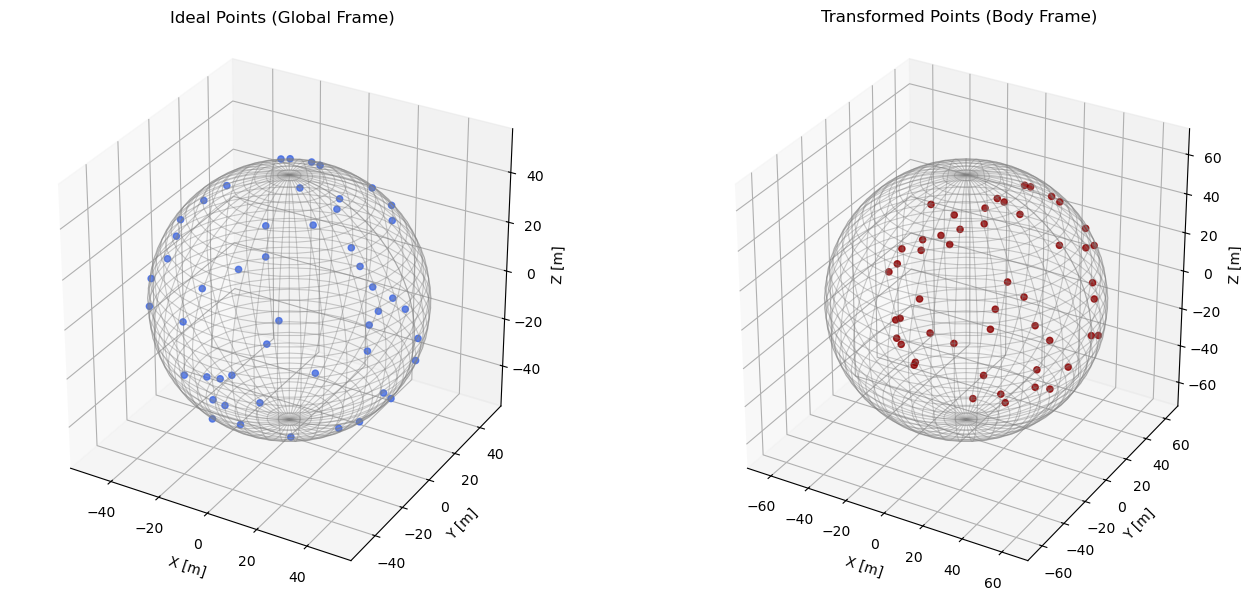

In [10]:
# assume transformed_sets exists with keys "ideal" → {"P_original", "P_transformed", ...}

# create output dir if not already present
os.makedirs("exports_img", exist_ok=True)

def plot_on_ax(ax, points, title, color):
    """
    Scatter 3D points plus a matching-radius wireframe sphere on the given Axes3D.
    """
    x, y, z = points
    # compute matching radius
    r = np.max(np.linalg.norm(points, axis=0))
    # build sphere wireframe
    u = np.linspace(0, 2*np.pi, 40)
    v = np.linspace(0, np.pi, 40)
    xw = r * np.outer(np.cos(u), np.sin(v))
    yw = r * np.outer(np.sin(u), np.sin(v))
    zw = r * np.outer(np.ones_like(u), np.cos(v))
    # plot
    ax.scatter(x, y, z, s=20, alpha=0.8, color=color)
    ax.plot_wireframe(xw, yw, zw, color="gray", linewidth=0.8, alpha=0.4)
    ax.set_title(title, pad=10)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    ax.set_box_aspect((1,1,1))

# === Subplot comparison ===
fig = plt.figure(figsize=(14,6))

# 1) Ideal points in Global Frame
ax1 = fig.add_subplot(1,2,1, projection="3d")
plot_on_ax(ax1,
           transformed_sets["ideal"]["P_original"],
           title="Ideal Points (Global Frame)",
           color="royalblue")

# 2) Same points after Rotation+Translation (Body Frame)
ax2 = fig.add_subplot(1,2,2, projection="3d")
plot_on_ax(ax2,
           transformed_sets["ideal"]["P_transformed"],
           title="Transformed Points (Body Frame)",
           color="darkred")

plt.tight_layout()
out_path = os.path.join("exports_img", "comparison_global_vs_body.jpg")
plt.savefig(out_path, dpi=300)
plt.show()


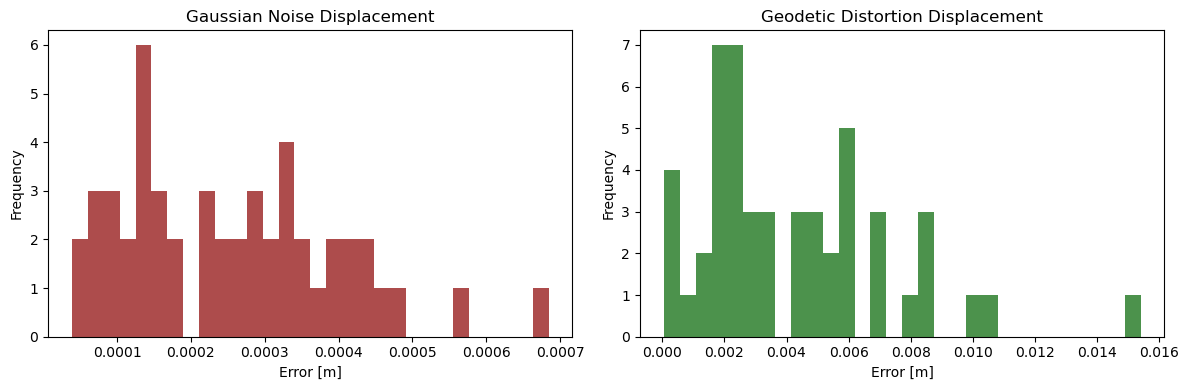

In [11]:
# === Noise Distribution Histograms ===

# Reference (ideal) points
P_ideal = transformed_sets["ideal"]["P_original"]

# Noisy (angle perturbation) points
P_noise = transformed_sets["with_noise"]["P_original"]

# Geodetic distortion points
P_dist  = transformed_sets["with_geodetic_distortion"]["P_original"]

# Compute displacement magnitudes
d_noise = np.linalg.norm(P_noise - P_ideal, axis=0)
d_dist  = np.linalg.norm(P_dist  - P_ideal, axis=0)

# Plot side‑by‑side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(d_noise, bins=30, color="darkred", alpha=0.7)
ax1.set_title("Gaussian Noise Displacement")
ax1.set_xlabel("Error [m]")
ax1.set_ylabel("Frequency")

ax2.hist(d_dist, bins=30, color="darkgreen", alpha=0.7)
ax2.set_title("Geodetic Distortion Displacement")
ax2.set_xlabel("Error [m]")
ax2.set_ylabel("Frequency")

plt.tight_layout()

# Save figure
hist_path = os.path.join("exports_img", "noise_histograms.jpg")
plt.savefig(hist_path, dpi=300)
plt.show()


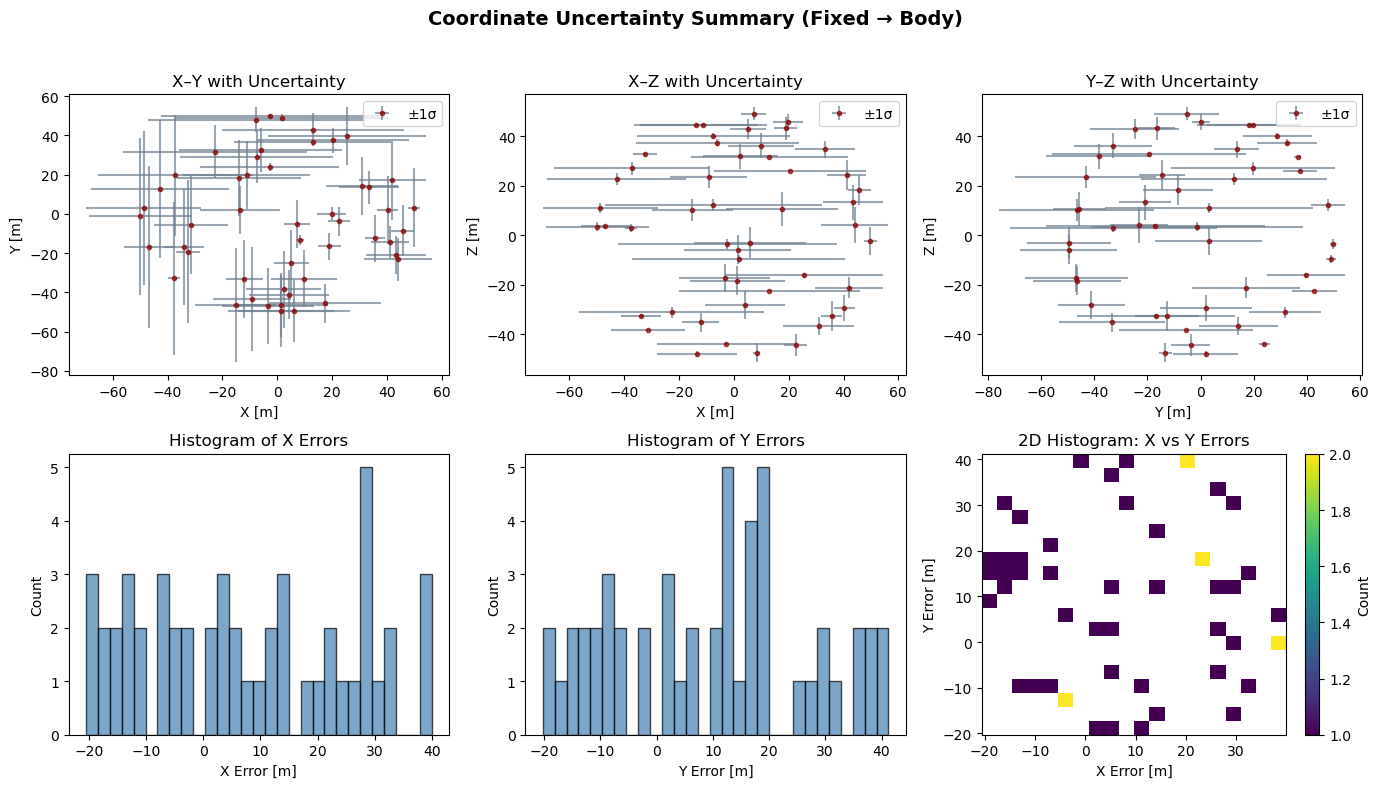

In [12]:
# === Coordinate Uncertainty Visualizations ===

# 1) Retrieve original and transformed coordinates
P_orig  = transformed_sets["ideal"]["P_original"]     # shape (3, N)
P_trans = transformed_sets["ideal"]["P_transformed"]  # shape (3, N)

# 2) Unpack into X, Y, Z vectors
xs, ys, zs       = P_orig
xst, yst, zst    = P_trans

# 3) Compute per-axis errors
error_x = xst - xs
error_y = yst - ys
error_z = zst - zs

# 4) Compute absolute errors for error bars
err_x = np.abs(error_x)
err_y = np.abs(error_y)
err_z = np.abs(error_z)

# 5) Create a 2×3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# a) X–Y scatter with error bars
ax = axes[0, 0]
ax.errorbar(xs, ys,
            xerr=err_x, yerr=err_y,
            fmt='o', markersize=3, color='darkred',
            ecolor='slategray', alpha=0.7, label='±1σ')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('X–Y with Uncertainty')
ax.legend()

# b) X–Z scatter with error bars
ax = axes[0, 1]
ax.errorbar(xs, zs,
            xerr=err_x, yerr=err_z,
            fmt='o', markersize=3, color='darkred',
            ecolor='slategray', alpha=0.7, label='±1σ')
ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]')
ax.set_title('X–Z with Uncertainty')
ax.legend()

# c) Y–Z scatter with error bars
ax = axes[0, 2]
ax.errorbar(ys, zs,
            xerr=err_y, yerr=err_z,
            fmt='o', markersize=3, color='darkred',
            ecolor='slategray', alpha=0.7, label='±1σ')
ax.set_xlabel('Y [m]')
ax.set_ylabel('Z [m]')
ax.set_title('Y–Z with Uncertainty')
ax.legend()


# d) Histogram of X errors
ax = axes[1, 0]
ax.hist(error_x, bins=np.linspace(error_x.min(), error_x.max(), 30),
        color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('X Error [m]')
ax.set_ylabel('Count')
ax.set_title('Histogram of X Errors')

# e) Histogram of Y errors
ax = axes[1, 1]
ax.hist(error_y, bins=np.linspace(error_y.min(), error_y.max(), 30),
        color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Y Error [m]')
ax.set_ylabel('Count')
ax.set_title('Histogram of Y Errors')

# f) 2D histogram of X vs Y errors
ax = axes[1, 2]
h = ax.hist2d(error_x, error_y, bins=20, cmap='viridis', cmin=1)
ax.set_xlabel('X Error [m]')
ax.set_ylabel('Y Error [m]')
ax.set_title('2D Histogram: X vs Y Errors')
plt.colorbar(h[3], ax=ax, label='Count')

# Figure super-title and layout
fig.suptitle('Coordinate Uncertainty Summary (Fixed → Body)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save to file and display
out_path = os.path.join("exports_img", "coordinate_uncertainty_summary.jpg")
plt.savefig(out_path, dpi=300)
plt.show()


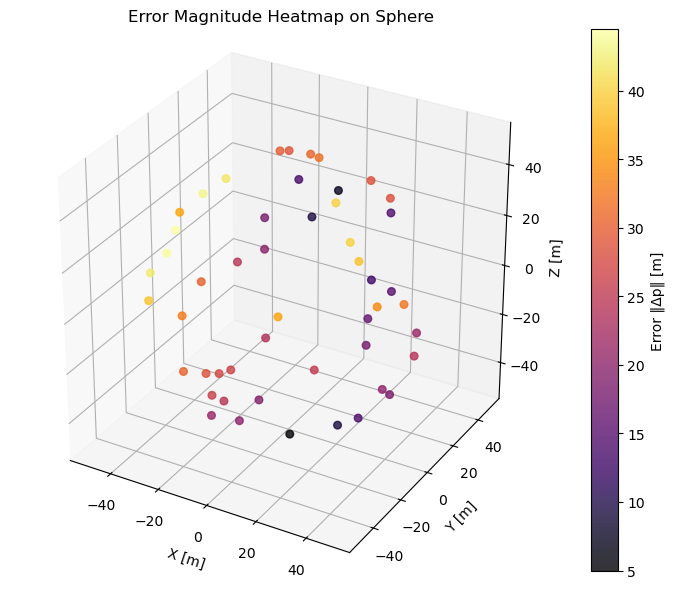

In [13]:
# === Heatmap of Error Magnitudes on Sphere ===

# Unpack global and body points
P_g = transformed_sets["ideal"]["P_original"]      # 3×N
P_b = transformed_sets["ideal"]["P_transformed"]   # 3×N

# Compute error magnitudes
errors = np.linalg.norm(P_b - P_g, axis=0)

# Convert spherical angles for plotting
theta = transformed_sets["ideal"]["theta"]
phi   = transformed_sets["ideal"]["phi"]
r     = config["radius"]

# Convert back to Cartesian for coloring
X = r * np.sin(phi) * np.cos(theta)
Y = r * np.sin(phi) * np.sin(theta)
Z = r * np.cos(phi)

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
p = ax.scatter(X, Y, Z, c=errors, cmap='inferno', s=30, alpha=0.8)
ax.set_title("Error Magnitude Heatmap on Sphere")
ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Z [m]")
ax.set_box_aspect((1,1,1))
fig.colorbar(p, ax=ax, label="Error ‖Δp‖ [m]")
plt.tight_layout()
plt.show()


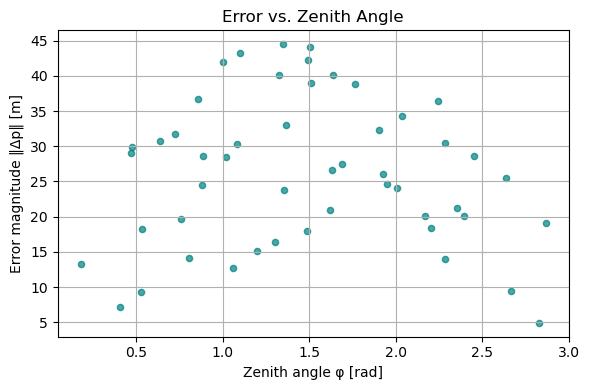

In [14]:
# === Error Magnitude vs. Zenith Angle ===

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(phi, errors, s=20, c='teal', alpha=0.7)
ax.set_xlabel("Zenith angle φ [rad]")
ax.set_ylabel("Error magnitude ‖Δp‖ [m]")
ax.set_title("Error vs. Zenith Angle")
ax.grid(True)
plt.tight_layout()
plt.show()


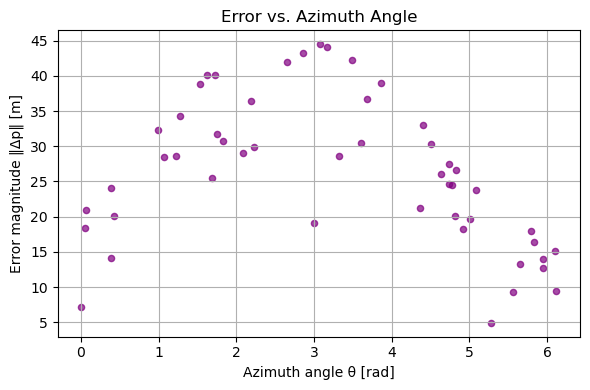

In [15]:
# === Error Magnitude vs. Azimuth Angle ===

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(theta, errors, s=20, c='purple', alpha=0.7)
ax.set_xlabel("Azimuth angle θ [rad]")
ax.set_ylabel("Error magnitude ‖Δp‖ [m]")
ax.set_title("Error vs. Azimuth Angle")
ax.grid(True)
plt.tight_layout()
plt.show()


/var/folders/23/v47_5r_j1cs3xhs3pyx1rxdh0000gn/T/ipykernel_56156/458155882.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([error_x, error_y, error_z],


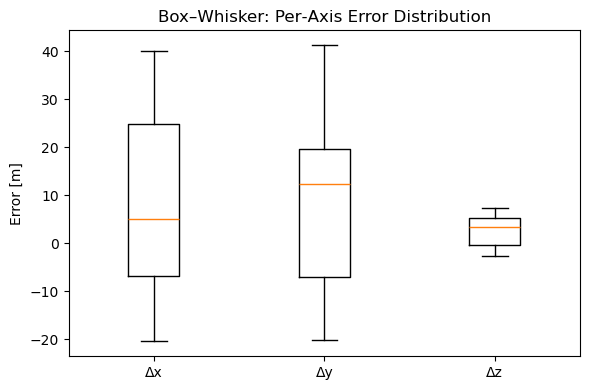

In [16]:
# === Box–Whisker for Δx, Δy, Δz ===

error_x = P_b[0] - P_g[0]
error_y = P_b[1] - P_g[1]
error_z = P_b[2] - P_g[2]

fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot([error_x, error_y, error_z],
           labels=['Δx','Δy','Δz'], showfliers=True)
ax.set_ylabel("Error [m]")
ax.set_title("Box–Whisker: Per‑Axis Error Distribution")
plt.tight_layout()
plt.show()


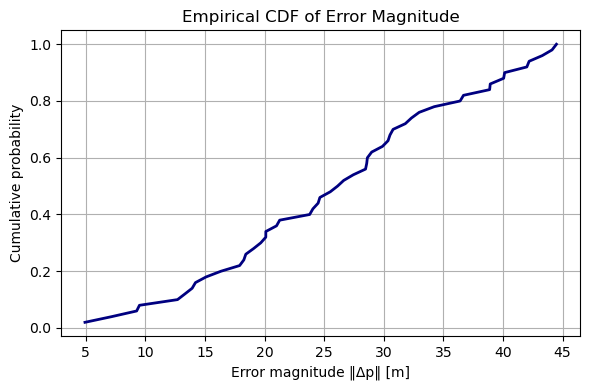

In [17]:
# === Empirical CDF of Error Magnitude ===

sorted_err = np.sort(errors)
cdf = np.arange(1, len(errors)+1) / len(errors)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(sorted_err, cdf, lw=2, color='navy')
ax.set_xlabel("Error magnitude ‖Δp‖ [m]")
ax.set_ylabel("Cumulative probability")
ax.set_title("Empirical CDF of Error Magnitude")
ax.grid(True)
plt.tight_layout()
plt.show()


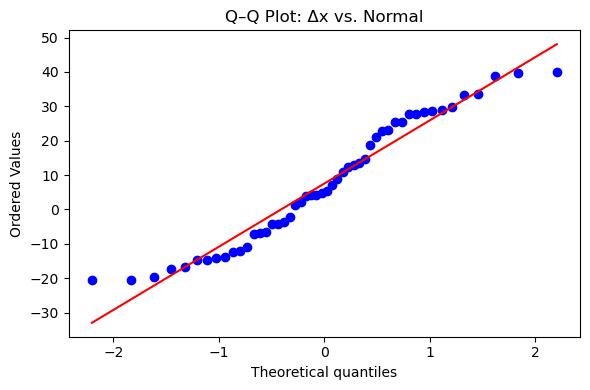

In [18]:
# === Q–Q Plot for Δx Errors ===
from scipy import stats

fig, ax = plt.subplots(figsize=(6,4))
stats.probplot(error_x, dist="norm", plot=ax)
ax.set_title("Q–Q Plot: Δx vs. Normal")
plt.tight_layout()
plt.show()


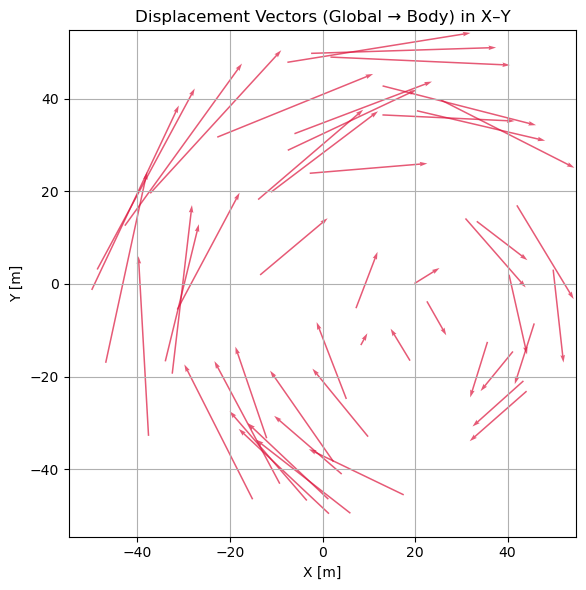

In [19]:
# === 2D Vector‑Field in X–Y Plane ===

fig, ax = plt.subplots(figsize=(6,6))
ax.quiver(P_g[0], P_g[1],
          (P_b[0]-P_g[0]), (P_b[1]-P_g[1]),
          angles='xy', scale_units='xy', scale=1, width=0.003,
          color='crimson', alpha=0.7)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Displacement Vectors (Global → Body) in X–Y")
ax.set_aspect('equal', 'box')
ax.grid(True)
plt.tight_layout()
plt.show()
